In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from sklearn.model_selection import train_test_split

In [2]:
# Number of QPSK symbols to be transmitted.
N = 100000

In [3]:
def mod(V):
    ip = np.zeros((len(V),1),dtype=complex)
    inc = 0
    for v in V:
        if(v==0):
            ip[inc] = -1.0 - 1j*1.0
        elif(v==1):
            ip[inc] = -1.0 + 1j*1.0
        elif(v==2):
            ip[inc] = 1.0 - 1j*1.0
        else:
            ip[inc] = 1.0 + 1j*1.0
        inc += 1
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    return s

def demod(c):
    c_seq = mod(np.array([0,1,2,3]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

In [5]:
# Create Es/N0 vector.
EsN0dB = np.arange(-2,22,2)

ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))
for idx in range(0,len(EsN0dB)):
    
    print('Es/N0 dB:', EsN0dB[idx])
    
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
    
    # Generate N binary symbols.
    V = np.random.randint(0,4,(N,1))
    
    # Modulate binary stream into QPSK symbols.
    s = mod(V)
    
    # Generate noise vector. 
    # Divide by two once the theoretical ber uses a complex Normal pdf with variance of each part = 1/2.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
    # Pass symbols through AWGN channel.
    y = s + np.sqrt(EsN0Lin)*noise
    
    # Split array into random train and test subsets.
    s_test, s_train, y_test, y_train, v_test, v_train = train_test_split(s, y, V, random_state=42)
    
    Y = np.c_[y_train.real,y_train.imag]
        
    # Fit models for real and imaginary parts.
    km = KMeans(n_clusters=4, random_state=42)
    km.fit(Y)
    
    # Prediction.
    detected = km.predict(np.c_[y_test.real,y_test.imag])   
        
    # Simulated QPSK BER.
    error = 0
    for i in range(0, len(v_test)):
        pred = km.cluster_centers_[detected[i],0] + 1j*km.cluster_centers_[detected[i],1]
        d = demod(pred)
        if((v_test[i,0] != d)==True): 
            error = error + 1
    
    ser_simu[idx] = 1.0 * error / len(v_test)
    
    # Theoretical BPSK BER.    
    ser_theo[idx] = erfc( np.sqrt(  0.5*(10.0**(EsN0dB[idx]/10.0))   ) ) - (1/4)*(erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))))**2.0;


Es/N0 dB: -2
Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10
Es/N0 dB: 12
Es/N0 dB: 14
Es/N0 dB: 16
Es/N0 dB: 18
Es/N0 dB: 20


In [6]:
# Print Es/N0 versus BER values.
for i in range(0,len(ser_simu)): print('Es/N0:%d \t- SER: %e' % (EsN0dB[i], ser_simu[i]))

Es/N0:-2 	- SER: 3.828667e-01
Es/N0:0 	- SER: 2.922533e-01
Es/N0:2 	- SER: 1.975867e-01
Es/N0:4 	- SER: 1.098267e-01
Es/N0:6 	- SER: 4.460000e-02
Es/N0:8 	- SER: 1.216000e-02
Es/N0:10 	- SER: 1.733333e-03
Es/N0:12 	- SER: 8.000000e-05
Es/N0:14 	- SER: 0.000000e+00
Es/N0:16 	- SER: 0.000000e+00
Es/N0:18 	- SER: 0.000000e+00
Es/N0:20 	- SER: 0.000000e+00


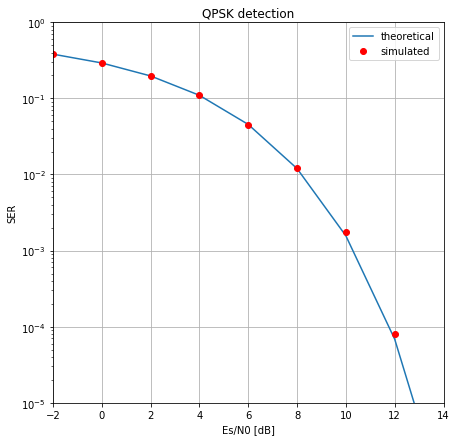

In [7]:
# Plot Es/N0 versus SER values.
fig = plt.figure(figsize=(7,7))
plt.plot(EsN0dB, ser_theo, label='theoretical')
plt.plot(EsN0dB, ser_simu, 'ro', label='simulated')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.title('QPSK detection')
plt.legend()
plt.xlim([-2, 14])
plt.ylim([1e-5, 1])
plt.show()